### interpolate orientations with fold axes

In [1]:
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm
from math import sin, cos, atan, atan2, asin, radians, degrees, sqrt, pow, acos
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import os
from shapely.geometry import Polygon
from shapely.geometry import Point
from map2loop import m2l_utils
from map2loop import m2l_interpolation
import rasterio

In [2]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "../test_data3/m2l_config.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-8200

#PATHS

test_data_path='../test_data3/'
geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
m2m_cpp_path='../m2m_cpp/'


#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#codes and labels these refer to specific fields (codes) in GIS layer or database that contain the info needed for these calcs and text substrings (labels) in the contents of these fie

In [3]:
use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) ################# MOVE UP   #########################
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

In [18]:
######################################
# Interpolate dipd,dipdirection data from shapefile usin fold axial traces as additional constraints     
######################################
def interpolate_orientations_with_fat(structure_file,output_path,bbox,c_l,this_gcode,calc,gridx,gridy):
    structure = gpd.read_file(structure_file,bbox=bbox)
    fat_orientations=pd.read_csv(output_path+'fold_axial_trace_orientations2.csv',",")
    
    
    
    if(len(this_gcode)==1):       
        is_gp=structure[c_l['g']] == thisgcode # subset orientations to just those with this group
        gp_structure = structure[is_gp]
        print('single group')
        display(gp_structure)
    else:
        print('first code',this_gcode[0])
        is_gp=structure[c_l['g']] == this_gcode[0] # subset orientations to just those with this group
        gp_structure = structure[is_gp]
        gp_structure_all = gp_structure.copy()
        print('first group')
        display(gp_structure)

        for i in range (1,len(this_gcode)):
            print('next code',this_gcode[i])
            is_gp=structure[c_l['g']] == this_gcode[i] # subset orientations to just those with this group
            temp_gp_structure = structure[is_gp]
            gp_structure_all = pd.concat([gp_structure_all, temp_gp_structure], ignore_index=True)
            print('next group')
            display(gp_structure)

    npts = len(gp_structure_all)+len(fat_orientations)
    
    nx, ny = gridx,gridy

    xi = np.linspace(bbox[0],bbox[2], nx)
    yi = np.linspace(bbox[1],bbox[3], ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()
    x = np.zeros(npts)
    y = np.zeros(npts)
    dip = np.zeros(npts)
    dipdir = np.zeros(npts)
    
    i=0
    for a_pt in gp_structure_all.iterrows():
        x[i]=a_pt[1]['geometry'].x
        y[i]=a_pt[1]['geometry'].y
        dip[i] = a_pt[1][c_l['d']]
        dipdir[i] = a_pt[1][c_l['dd']]
        i=i+1

    for a_pt in fat_orientations.iterrows():
        x[i]=a_pt[1]['X']
        y[i]=a_pt[1]['Y']
        dip[i] = a_pt[1]['dip']
        dipdir[i] = a_pt[1]['azimuth']
        i=i+1
    
    l=np.zeros(npts)
    m=np.zeros(npts)
    n=np.zeros(npts)
    
    for i in range(0,npts):
        l[i],m[i],n[i]=m2l_utils.ddd2dircos(dip[i],dipdir[i])

    ZIl,ZIm,ZIn=m2l_interpolation.call_interpolator(calc,x,y,l,m,n,xi,yi,nx,ny)
    
    # Comparisons...
    m2l_interpolation.plot(x,-y,l,ZIl)
    plt.title('l')
    m2l_interpolation.plot(x,-y,m,ZIm)
    plt.title('m')
    m2l_interpolation.plot(x,-y,n,ZIn)
    plt.title('n')
    
    plt.show()
    
    f=open(output_path+'input.csv','w')
    fi=open(output_path+'interpolation_'+calc+'.csv','w')
    fl=open(output_path+'interpolation_l.csv','w')
    fm=open(output_path+'interpolation_m.csv','w')
    fn=open(output_path+'interpolation_n.csv','w')
    
    f.write("x,y,dip,dipdirection\n")
    fi.write("x,y,dip,dipdirection\n")
    fl.write("x,y,l\n")
    fm.write("x,y,m\n")
    fn.write("x,y,n\n")
    
    for i in range (0,npts):
        ostr=str(x[i])+","+str(y[i])+","+str(int(dip[i]))+","+str(int(dipdir[i]))+'\n'
        f.write(ostr)
    
    for xx in range (0,gridx):
        for yy in range (0,gridy):
            yyy=xx
            xxx=gridy-2-yy
            L=ZIl[xxx,yyy]/(sqrt((pow(ZIl[xxx,yyy],2.0))+(pow(ZIm[xxx,yyy],2.0))+(pow(ZIn[xxx,yyy],2.0))))
            M=ZIm[xxx,yyy]/(sqrt((pow(ZIl[xxx,yyy],2.0))+(pow(ZIm[xxx,yyy],2.0))+(pow(ZIn[xxx,yyy],2.0))))
            N=ZIn[xxx,yyy]/(sqrt((pow(ZIl[xxx,yyy],2.0))+(pow(ZIm[xxx,yyy],2.0))+(pow(ZIn[xxx,yyy],2.0))))
            
            dip,dipdir=m2l_utils.dircos2ddd(L,M,N)

            ostr=str(bbox[0]+(xx*((bbox[2]-bbox[0])/gridx)))+","+str(bbox[1]+((gridy-1-yy)*((bbox[3]-bbox[1])/gridy)))+","+str(int(dip))+","+str(int(dipdir))+'\n'
            fi.write(ostr)
            
            ostr=str(xx)+","+str(yy)+","+str(L)+'\n'
            fl.write(ostr)
            ostr=str(xx)+","+str(yy)+","+str(M)+'\n'
            fm.write(ostr)
            ostr=str(xx)+","+str(yy)+","+str(N)+'\n'
            fn.write(ostr)
    
    f.close()
    fi.close()
    fl.close()
    fm.close()
    fn.close()
    
    fig, ax = plt.subplots(figsize=(10, 10),)
    q = ax.quiver(xi, yi, -ZIm, ZIl,headwidth=0)
    plt.show()
    print("orientations interpolated as dip dip direction",output_path+'interpolation_'+calc+'.csv')
    print("orientations interpolated as l,m,n dir cos",output_path+'interpolation_l.csv etc.')




first code Hamersley Group
first group


,DIP,DIP_DIR,FEATURE,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,"Bedding, showing strike and dip",71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,"Bedding, showing strike and dip",134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,"Bedding, showing strike and dip",3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,"Bedding, showing strike and dip",124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,"Bedding, showing strike and dip",184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


next code Fortescue Group
next group


,DIP,DIP_DIR,FEATURE,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,"Bedding, showing strike and dip",71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,"Bedding, showing strike and dip",134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,"Bedding, showing strike and dip",3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,"Bedding, showing strike and dip",124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,"Bedding, showing strike and dip",184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


next code Wyloo Group
next group


,DIP,DIP_DIR,FEATURE,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,"Bedding, showing strike and dip",71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,"Bedding, showing strike and dip",134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,"Bedding, showing strike and dip",3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,"Bedding, showing strike and dip",124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,"Bedding, showing strike and dip",184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


next code Shingle Creek Group
next group


,DIP,DIP_DIR,FEATURE,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,"Bedding, showing strike and dip",71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,"Bedding, showing strike and dip",134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,"Bedding, showing strike and dip",3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,"Bedding, showing strike and dip",124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,"Bedding, showing strike and dip",184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


next code Turee Creek Group
next group


,DIP,DIP_DIR,FEATURE,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,"Bedding, showing strike and dip",71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,"Bedding, showing strike and dip",134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,"Bedding, showing strike and dip",3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,"Bedding, showing strike and dip",124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,"Bedding, showing strike and dip",184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,"Bedding, showing strike and dip",119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


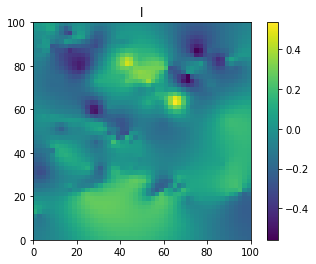

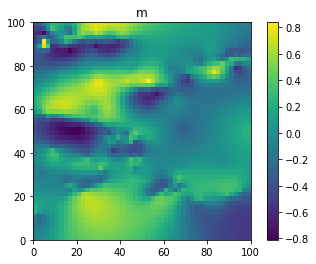

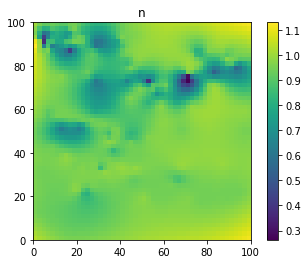

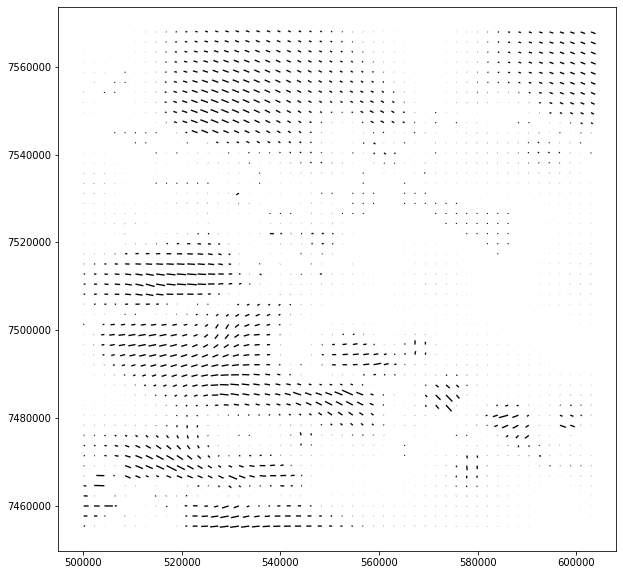

orientations interpolated as dip dip direction ../test_data3/output/interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data3/output/interpolation_l.csv etc.


In [19]:
xxxinterpolate_orientations(structure_file,output_path,bbox,c_l,use_gcode,scheme,gridx,gridy)
